In [225]:
#!pip3 install lightgbm

### Intuition of Quantile Loss 

Typical Loss Function:

$$ L = (y - X\theta)^2 $$

Quantile Loss:

$$
\begin{equation}
  L =
    \begin{cases}
      \tau (y - X\theta) & \text{if $y - X\theta\ge 0$}\\
      (\tau - 1) (y - X\theta) & \text{if $y - X\theta < 0$ }\\
    \end{cases}       
\end{equation}
$$

We want to penilze loss if:
- the percentile $\tau$ is low, but the prediction $X\theta$ is high
- the percentile $\tau$ is high, but the prediction $X\theta$ is low

### Problem

Let's build a regression model that determines delivery time based on distance of house from store.

### Build Dataset

In [91]:
from sklearn.datasets import make_regression
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from lightgbm import LGBMRegressor

In [68]:
X, y = make_regression(n_samples=10000,
                n_features=1,
                n_informative=1,
                n_targets=1,
                random_state=42)

Xs = pd.DataFrame(X, columns = ['distance'])
ys = pd.DataFrame(y, columns = ['time_to_buyer'])

Xs['distance'] = Xs['distance'].apply(lambda x: 10 + 2 * (x + np.random.normal(loc=1))  )
ys['time_to_buyer'] = ys['time_to_buyer'].apply(lambda x: 60 + 0.3* (x + np.random.normal(loc=1)) )

In [69]:
df = Xs.merge(ys, left_index=True, right_index=True)

In [70]:
df.describe()

,distance,time_to_buyer
count,10000.000000,10000.000000
mean,12.057023,60.281775
std,2.842749,9.673767
min,0.979318,22.305135
25%,10.151418,53.779436
50%,12.058350,60.278309
75%,13.912213,66.753501
max,22.255286,98.650239


In [192]:
train_df, test_df = train_test_split(df, test_size=0.10, shuffle=False)

In [196]:
X_train, y_train = train_df[['distance']], train_df[['time_to_buyer']]
X_test, y_test = test_df[['distance']], test_df[['time_to_buyer']]

### Visualize Data 

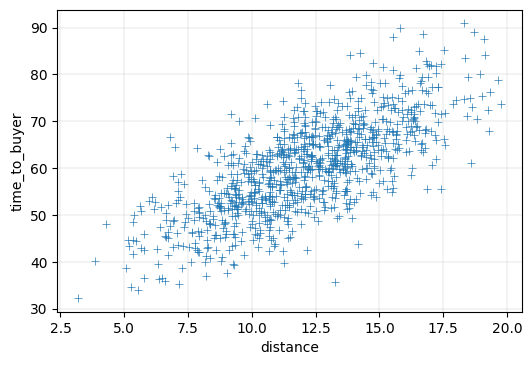

In [219]:
plt.rcParams.update({'font.size': 10, 'figure.dpi':100})
sns.scatterplot(data=test_df, x="distance", y="time_to_buyer", marker='+')
plt.grid(linestyle='-', linewidth=0.2)

In [130]:
classifiers = {}
for tau in [0.1, 0.5, 0.9]:
    clf = LGBMRegressor(objective='quantile', alpha=tau)
    clf.fit(X_train, y_train)
    preds = pd.DataFrame(clf.predict(X_test), columns = [str(tau)])
    classifiers[str(tau)] = {'clf': clf, 'predictions': preds}

In [202]:
data = pd.DataFrame({'distance': X_test.reset_index()['distance'],
              '0.1': classifiers['0.1']['predictions']['0.1'],
              '0.5': classifiers['0.5']['predictions']['0.5'],
              '0.9': classifiers['0.9']['predictions']['0.9'],
              'time_to_buyer': y_test.reset_index()['time_to_buyer']})

In [227]:
data.sample(2)

,distance,0.1,0.5,0.9,time_to_buyer
983,12.737685,53.898628,64.019707,70.668183,54.395450
49,9.839226,46.987381,54.746463,63.828678,66.579161


In [203]:
melted_data = pd.melt(data, id_vars=['distance'])

In [204]:
melted_data

,distance,variable,value
0,8.319658,0.1,43.732981
1,12.635766,0.1,52.091116
2,14.856894,0.1,57.633999
3,12.989553,0.1,54.474616
4,14.268261,0.1,57.370992
...,...,...,...
3995,13.781641,time_to_buyer,62.560813
3996,13.940305,time_to_buyer,60.498947
3997,16.837392,time_to_buyer,76.516125
3998,10.501499,time_to_buyer,54.109174


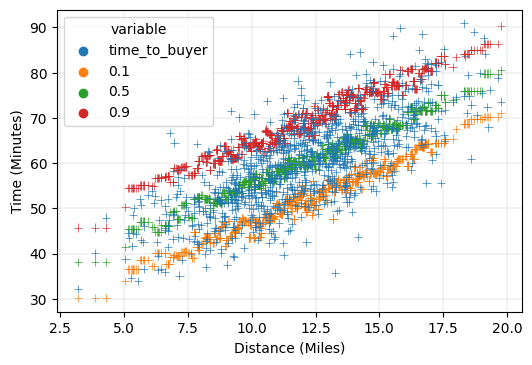

In [217]:
plt.rcParams.update({'font.size': 10, 'figure.dpi':100})
sns.scatterplot(data=melted_data, 
                x="distance",
                y='value',
                hue='variable',
                hue_order=['time_to_buyer', '0.1', '0.5', '0.9'],
                marker='+')
plt.grid(linestyle='-', linewidth=0.2)
ylabel = plt.ylabel("Time (Minutes)")
xlabel = plt.xlabel("Distance (Miles)")

In [222]:
(data['time_to_buyer'] > data['0.1']).value_counts()

True     884
False    116
dtype: int64

In [223]:
(data['time_to_buyer'] > data['0.5']).value_counts()

False    532
True     468
dtype: int64

In [224]:
(data['time_to_buyer'] > data['0.9']).value_counts()

False    900
True     100
dtype: int64

### Notes

- Instacart: https://tech.instacart.com/how-instacart-delivers-on-time-using-quantile-regression-2383e2e03edb
- Quantile Regression blog: http://ethen8181.github.io/machine-learning/ab_tests/quantile_regression/quantile_regression.html